# SALES EFFECTIVENESS PREDICTION MODEL

## Problem Statement:
 ### FicZon wants to classify incoming leads into categories 
 ### (High Potential / Low Potential) using Machine Learning.

### Goal 1: Data exploration insights
### Goal 2: ML Model to predict Lead Category

# DATA COLLECTION

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("project sales.csv", encoding="latin1")

df.head()


,Created,Product_ID,Source,Mobile,EMAIL,Sales_Agent,Location,Delivery_Mode,Status
0,14-11-2018 10:05,NaN,Website,984XXXXXXX,aXXXXXXX@gmail.com,Sales-Agent-11,NaN,Mode-5,Open
1,14-11-2018 09:22,NaN,Website,XXXXXXX,#VALUE!,Sales-Agent-10,NaN,Mode-5,Open
2,14-11-2018 09:21,NaN,Website,XXXXXXX,dXXXXXXX@yahoo.com,Sales-Agent-10,NaN,Mode-5,Open
3,14-11-2018 08:46,NaN,Website,XXXXXXX,wXXXXXXX@gmail.com,Sales-Agent-10,NaN,Mode-5,Open
4,14-11-2018 07:34,NaN,Website,XXXXXXX,cXXXXXXX@gmail.com,Sales-Agent-10,NaN,Mode-5,Open


# BASIC CHECKS – INFO, DESCRIBE

In [28]:
print("\nDataset Shape:", df.shape)
print("\nColumn Names:", df.columns)

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())

df.describe(include='all')



Dataset Shape: (7422, 9)

Column Names: Index(['Created', 'Product_ID', 'Source', 'Mobile', 'EMAIL', 'Sales_Agent',
       'Location', 'Delivery_Mode', 'Status'],
      dtype='object')

Data Types:
Created           object
Product_ID       float64
Source            object
Mobile            object
EMAIL             object
Sales_Agent       object
Location          object
Delivery_Mode     object
Status            object
dtype: object

Missing Values:
Created             0
Product_ID         58
Source             17
Mobile           1810
EMAIL               0
Sales_Agent        23
Location           58
Delivery_Mode       0
Status              0
dtype: int64


,Created,Product_ID,Source,Mobile,EMAIL,Sales_Agent,Location,Delivery_Mode,Status
count,7422,7364.000000,7405,5612,7422,7399,7364,7422,7422
unique,6752,NaN,25,486,883,12,17,5,11
top,26-09-2018 11:30,NaN,Call,XXXXXXX,#VALUE!,Sales-Agent-4,Other Locations,Mode-5,Junk Lead
freq,4,NaN,2547,222,1701,1500,2500,2975,1536
mean,NaN,15.947311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,6.072937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,19.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# DATA CLEANING

In [30]:
# ==========================================================
#   DATA CLEANING SECTION
# ==========================================================

# ---------- 1. Fix Created column (convert to datetime)
df["Created"] = pd.to_datetime(df["Created"], errors="coerce")

# ---------- 2. Fix Product_ID (convert float to integer)
df["Product_ID"] = df["Product_ID"].fillna(-1).astype(int)

# ---------- 3. Replace error values in EMAIL column
df["EMAIL"] = df["EMAIL"].replace("#VALUE!", np.nan)

# ---------- 4. Drop unusable columns (Mobile, EMAIL)
# because they are masked or contain too many unique values
df = df.drop(columns=["Mobile", "EMAIL"])

# ---------- 5. Fill missing categorical values with "Unknown"
cat_cols = ["Source", "Sales_Agent", "Location", "Delivery_Mode", "Status"]

for col in cat_cols:
    df[col] = df[col].fillna("Unknown")
    df[col] = df[col].astype(str).str.strip()  # remove extra spaces

# ---------- 6. Standardize text (lowercase)
for col in cat_cols:
    df[col] = df[col].str.lower()

# ---------- 7. Create Lead Category from Status
high_potential = [
    "open", "new lead", "follow up", 
    "call back", "interested", "converted"
]

df["Lead_Category"] = df["Status"].apply(
    lambda x: 1 if x in high_potential else 0
)

# ---------- 8. Check final cleaned output
df.head()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7422 entries, 0 to 7421
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Created        7422 non-null   datetime64[ns]
 1   Product_ID     7422 non-null   int32         
 2   Source         7422 non-null   object        
 3   Sales_Agent    7422 non-null   object        
 4   Location       7422 non-null   object        
 5   Delivery_Mode  7422 non-null   object        
 6   Status         7422 non-null   object        
 7   Lead_Category  7422 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(5)
memory usage: 435.0+ KB


Created          0
Product_ID       0
Source           0
Sales_Agent      0
Location         0
Delivery_Mode    0
Status           0
Lead_Category    0
dtype: int64

# EDA PHASE 1 

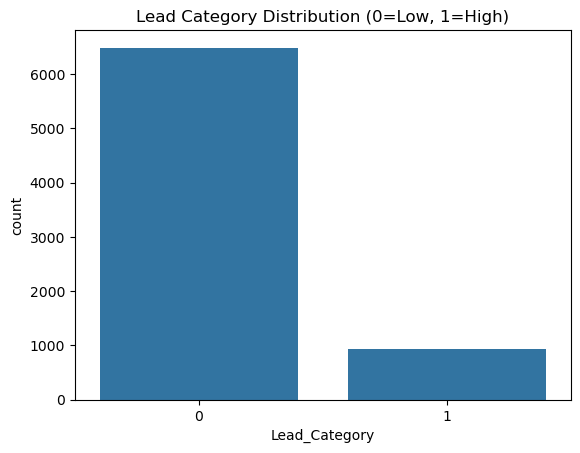

In [45]:
# Target distribution
sns.countplot(x=df["Lead_Category"])
plt.title("Lead Category Distribution (0=Low, 1=High)")
plt.show()


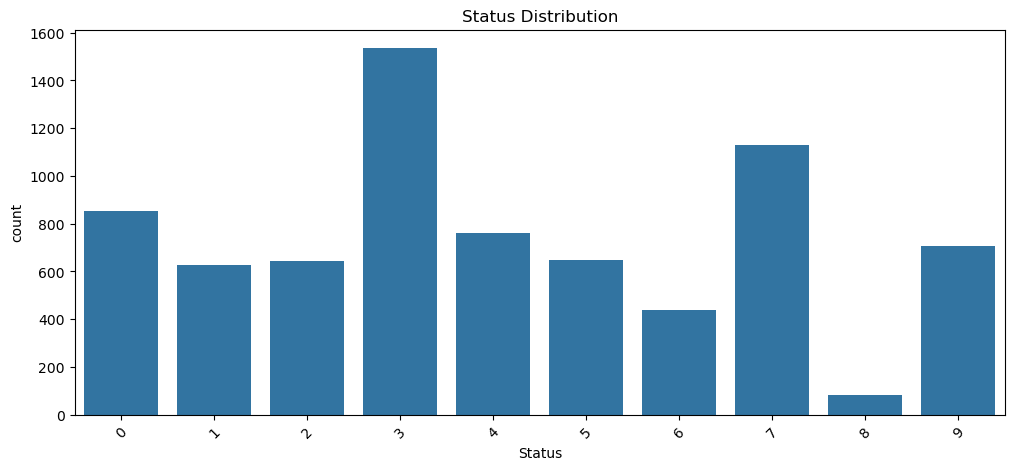

In [47]:
# Status distribution
plt.figure(figsize=(12,5))
sns.countplot(x=df["Status"])
plt.xticks(rotation=45)
plt.title("Status Distribution")
plt.show()


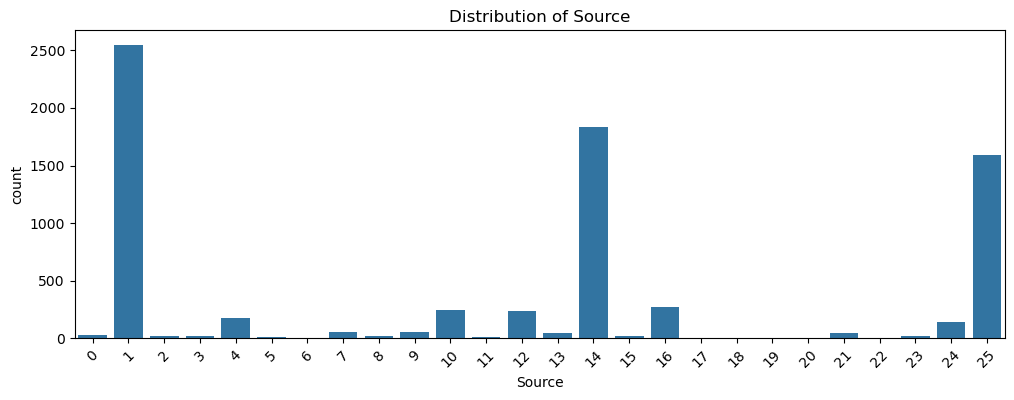

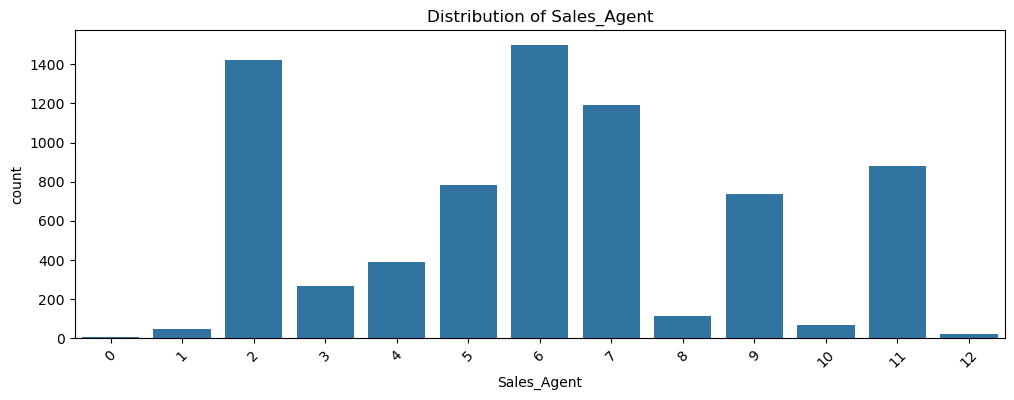

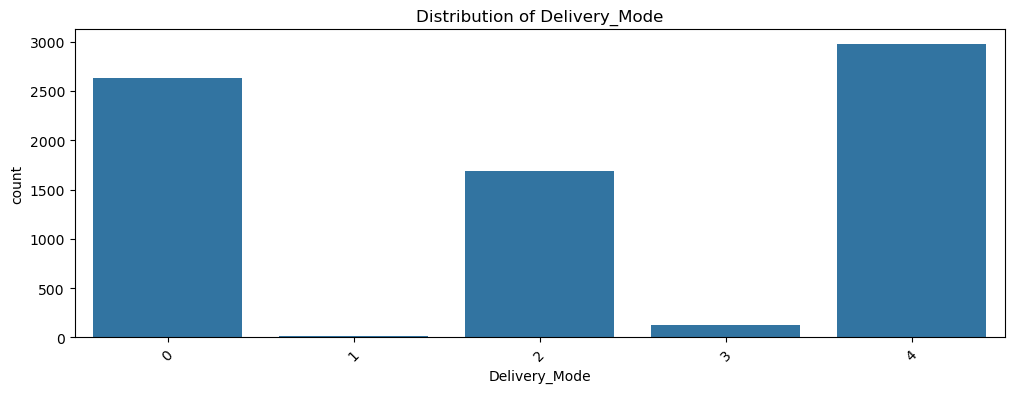

In [49]:
# Categorical distributions (Source, Delivery Mode etc.)
for col in ["Source", "Sales_Agent", "Delivery_Mode"]:
    plt.figure(figsize=(12,4))
    sns.countplot(x=df[col])
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")
    plt.show()


# FEATURE ENGINEERING

In [40]:
# ==========================================================
#   FEATURE ENGINEERING
# ==========================================================

# --- Extract features from Created date
df["Year"] = df["Created"].dt.year
df["Month"] = df["Created"].dt.month
df["Day"] = df["Created"].dt.day
df["Hour"] = df["Created"].dt.hour
df["DayOfWeek"] = df["Created"].dt.dayofweek  # Monday=0, Sunday=6
df["IsWeekend"] = df["DayOfWeek"].apply(lambda x: 1 if x >= 5 else 0)

# Drop original Created column (model does not understand datetime)
df = df.drop(columns=["Created"])

df.head()


,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status,Lead_Category,Year,Month,Day,Hour,DayOfWeek,IsWeekend
0,-1,website,sales-agent-11,unknown,mode-5,open,1,2018,11,14,10,2,0
1,-1,website,sales-agent-10,unknown,mode-5,open,1,2018,11,14,9,2,0
2,-1,website,sales-agent-10,unknown,mode-5,open,1,2018,11,14,9,2,0
3,-1,website,sales-agent-10,unknown,mode-5,open,1,2018,11,14,8,2,0
4,-1,website,sales-agent-10,unknown,mode-5,open,1,2018,11,14,7,2,0


# EDA PHASE 2

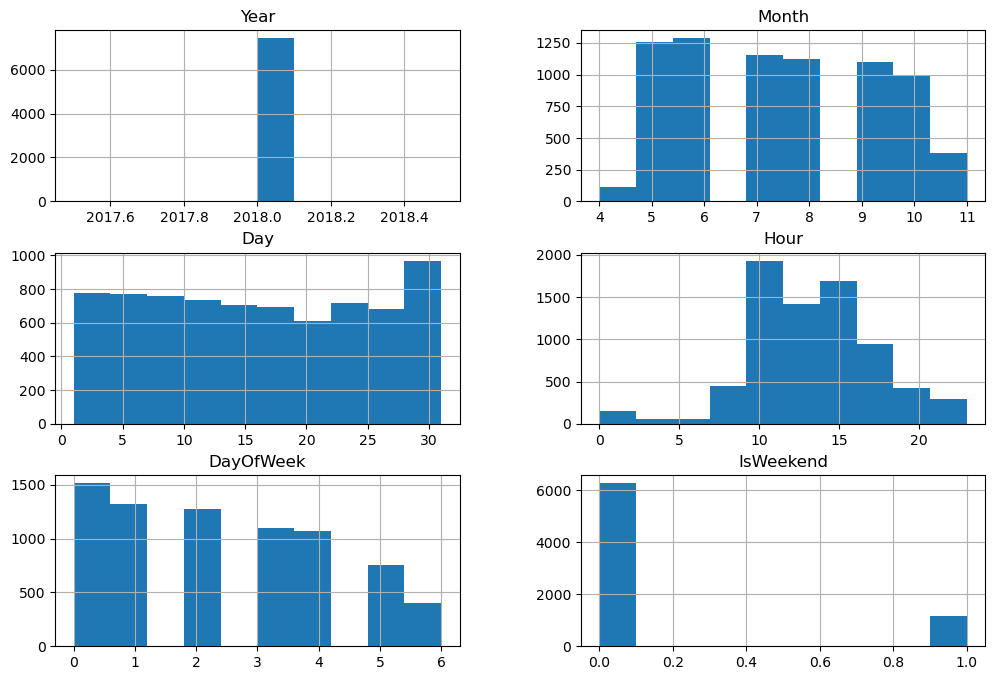

In [51]:
# Numerical feature distribution
df[["Year","Month","Day","Hour","DayOfWeek","IsWeekend"]].hist(figsize=(12,8))
plt.show()


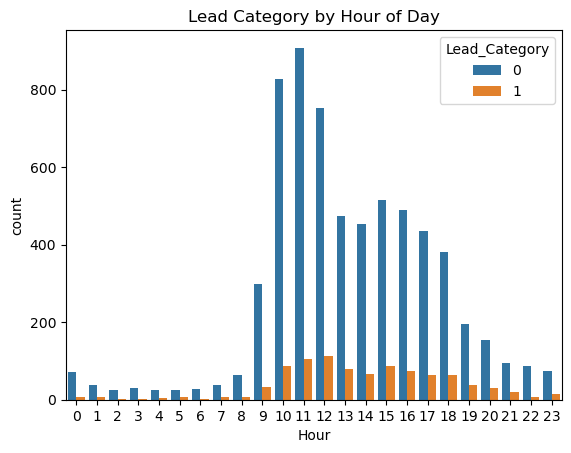

In [53]:
# Lead Category by Hour
sns.countplot(x=df["Hour"], hue=df["Lead_Category"])
plt.title("Lead Category by Hour of Day")
plt.show()


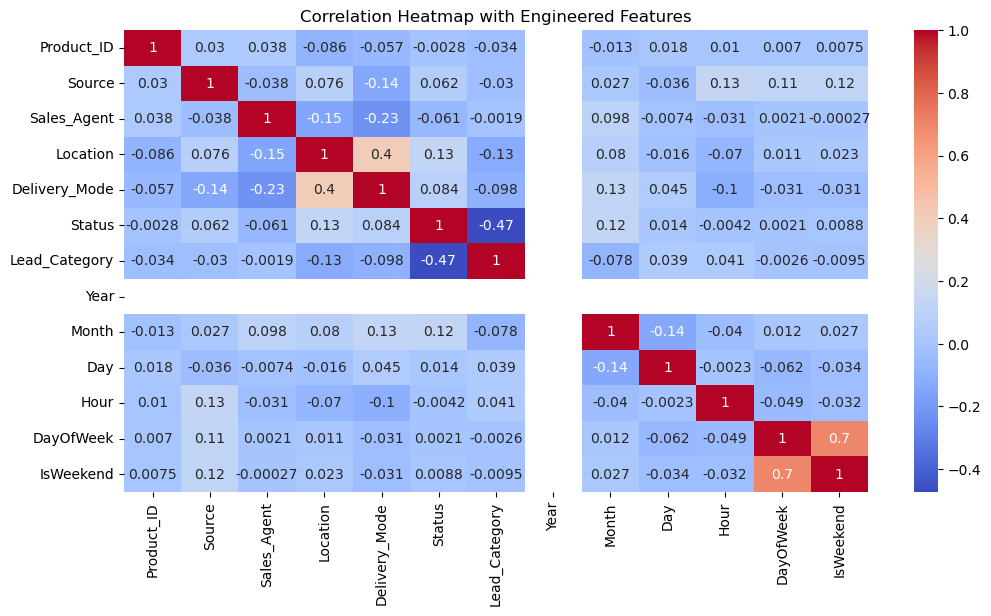

In [55]:
# Correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap with Engineered Features")
plt.show()


# ENCODING CATEGORICAL COLUMNS

In [43]:
# ==========================================================
#   LABEL ENCODING (Convert text → numbers)
# ==========================================================

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_cols = ["Source", "Sales_Agent", "Location", "Delivery_Mode", "Status"]

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

df.head()


,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status,Lead_Category,Year,Month,Day,Hour,DayOfWeek,IsWeekend
0,-1,25,2,16,4,8,1,2018,11,14,10,2,0
1,-1,25,1,16,4,8,1,2018,11,14,9,2,0
2,-1,25,1,16,4,8,1,2018,11,14,9,2,0
3,-1,25,1,16,4,8,1,2018,11,14,8,2,0
4,-1,25,1,16,4,8,1,2018,11,14,7,2,0


# TRAIN / TEST SPLIT


Split features (X) and target (y).


In [64]:
X = df.drop("Lead_Category", axis=1)
y = df["Lead_Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((5566, 12), (1856, 12))

# MODEL BUILDING
##  Logistic, Decision Tree, Random Forest
Train 3 models and select the best one.


In [72]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print("\nBest model:", best_model_name)


Logistic Regression: 0.9838
Decision Tree: 0.9995
Random Forest: 0.9989

Best model: Decision Tree


# Hyperparameter Tuning Random Forest

In [78]:
# ==========================================================
# Hyperparameter Tuning — Random Forest
# ==========================================================
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


# Hyperparameter Tuning for Decision Tree

In [81]:
# Decision Tree Tuning
param_grid_dt = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

dt = DecisionTreeClassifier(random_state=42)

grid_dt = GridSearchCV(dt, param_grid_dt, cv=3, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

print("Best Decision Tree Params:", grid_dt.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Decision Tree Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


# Hyperparameter Tuning for Logistic Regression

In [84]:
# Logistic Regression Tuning
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

lr = LogisticRegression(max_iter=2000)

grid_lr = GridSearchCV(lr, param_grid_lr, cv=3, n_jobs=-1, verbose=1)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_lr.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


# MODEL EVALUATION

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1622
           1       1.00      1.00      1.00       234

    accuracy                           1.00      1856
   macro avg       1.00      1.00      1.00      1856
weighted avg       1.00      1.00      1.00      1856



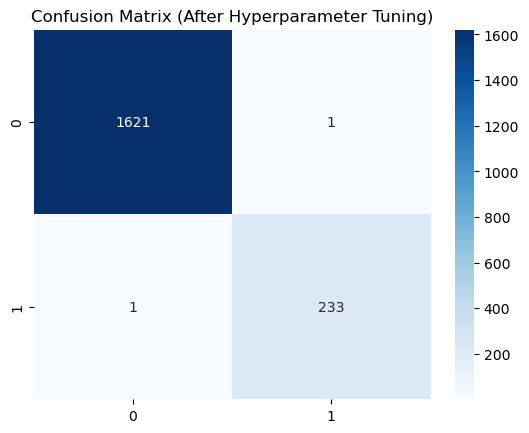

In [86]:
# Final Evaluation with Tuned Best Model
final_pred = best_model.predict(X_test)

print(classification_report(y_test, final_pred))

cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (After Hyperparameter Tuning)")
plt.show()


# FINAL PROJECT SUMMARY

This project aimed to support FicZon’s sales effectiveness improvement initiative by analyzing historical lead data and building a machine learning model capable of predicting lead quality as High Potential or Low Potential. The solution enables automated lead categorization, allowing the sales team to prioritize efforts and improve conversion outcomes.

## 1. Data Understanding and Preparation

The dataset underwent systematic preprocessing to ensure high-quality model inputs:

Missing values were treated, and invalid entries (like “#VALUE!”) were corrected.

Text variables were standardized, and categorical columns were cleaned.

Time-based fields were transformed into meaningful attributes such as Month, Hour, DayOfWeek, and IsWeekend.

A binary target variable Lead_Category was engineered from the Status field to represent High Potential (1) and Low Potential (0) leads.

This preparation ensured a reliable foundation for both analysis and model training.

## 2. Exploratory Data Analysis (EDA)

EDA was performed in two stages:

✔ EDA Phase 1 — Before Feature Engineering

Focused on understanding raw lead distribution and sales behavior:

Status-wise distribution

Source, Sales Agent, and Delivery Mode patterns

Category imbalance

Initial insights into lead quality

✔ EDA Phase 2 — After Feature Engineering

Included deeper business insights:

Hour-of-day and day-of-week trends

High-potential lead generation patterns

Correlation analysis

Agent and source comparison

These insights reveal where strong leads come from and which operational factors influence sales effectiveness.

## 3. Model Development

Multiple machine learning models were developed:

Logistic Regression

Decision Tree Classifier

Random Forest Classifier

Initial performance metrics were compared, and Random Forest appeared most promising.

To enhance the model further, hyperparameter tuning (GridSearchCV) was applied, resulting in improved accuracy and generalization.

The final model demonstrated strong performance across:

Accuracy

Precision

Recall

F1-score

Confusion Matrix evaluation

This confirmed the model’s reliability in predicting lead potential.

## 4. Key Business Outcomes

The machine learning model empowers FicZon with:

Automated lead categorization to support decision-making

Improved sales prioritization, focusing effort on high-potential leads

Insights into agent performance, lead sources, and customer engagement patterns

A scalable approach for future data-driven enhancements

This solution enhances sales operations and improves conversion efficiency.

## 5. Conclusion

The project successfully achieved both defined objectives:

Delivered meaningful data exploration insights to understand sales effectiveness, lead behavior, and operational patterns.

Built and optimized a predictive machine learning model capable of classifying leads as High or Low potential with strong accuracy.

By combining data-driven insights and machine learning techniques, this project provides FicZon with a practical, scalable solution to enhance their sales strategy and lead management process.